In [1]:
import numpy as np
from numpy.linalg import norm
import ipywidgets as widgets
rng = np.random.default_rng(12345)
import matplotlib.pyplot as plt
import time 
import seaborn as sns
sns.set_theme()

from Pedestrian import Pedestrian
from Environment import Environment

## Crowd microscopic model
- Only 1 target with not intermediate sub-targets
- Speed is constant 
- Minimise loss from deviating from straight line to target + personal space invaded by forcasted move of sorrounding pedestrians + presence of close fixed obstacles. Namely, for pedestrian $i$:
$$
L_{i,\theta^*_i}(\theta) = c_{\text{dir}}|\theta-\theta^*_i|^2 + c_{\text{ped}} /\Big(1+\sum_{j\neq i}^J \|p^e_j-p^e_i(\theta)\|^2\Big) +c_{\text{obs}}/\Big(\sum_{m=1}^M \|obs_m-p^e_i(\theta)\|^2 \mathbb I(\text{if }\le 3 \,\&\, \theta\text{ towards }obs_m)\Big)
$$
where $J$ is the number of pedestrians, $M$ the number of obstacles $obs_m$'s (norm here means point-to-line distance). First is an inconvenience term (no accelleration part, also no frustration), second and third terms are a discomfort terms.

### How to run
1. Choose your environment by instantiating `env = Environment()`, and by passing a list of pairs of vectors `list_endpoints_obstacles`, which will define the  enpoints of all the (straight) obstacles present in the environments. 
2. Generate a list of pedestrians instantiating  `Pedestrian` and passing the environments obstacles `env.obstacles`. 
3. Pass the list of pedestrians to the function `simulate`.

## Construct some environments

In [2]:
bar_end1 = [np.array([75,50]),np.array([20,25])] 
bar_end2 = [np.array([15,80]), np.array([10,25])] 
obstacles = [bar_end1, bar_end2]

wagons = Environment(obstacles, name="Wagons")

bar_end1 = [np.array([20,15]),np.array([25,70])] 
bar_end2 = [np.array([10,15]),np.array([15,70])]
bar_end3 = [np.array([25,70]),np.array([150,70])] 
bar_end4 = [np.array([15,70]),np.array([-100,70])] 
bar_end5 = [np.array([150,150]),np.array([150,70])] 
bar_end6 = [np.array([-100,150]),np.array([-100,70])] 

obstacles = [bar_end1, bar_end2, bar_end3, bar_end4,bar_end5, bar_end6]
corridor = Environment(obstacles, name="Corridor")


#Corridor
height, width, left, right, wagon_x, wagon_y = 55, 10, 20, 60, 50, 15
bar_end1 = [np.array([left,height]),np.array([right,height])]
bar_end2 = [np.array([left,height-width]),np.array([right,height-width])]
bar_end3 = [np.array([right,height]),np.array([right+wagon_x,height+wagon_y])]
bar_end4 = [np.array([right,height-width]),np.array([right+wagon_x,height-width-wagon_y])]
bar_end5 = [np.array([left,height]),np.array([left-wagon_x,height+wagon_y])]
bar_end6 = [np.array([left,height-width]),np.array([left-wagon_x,height-width-wagon_y])]

obstacles = [bar_end1, bar_end2, bar_end3, bar_end4,bar_end5, bar_end6]
corridor_two_way = Environment(obstacles, name="Corridor two way")

"""
wagons.plot()
corridor.plot()
corridor_two_way.plot() 
""";

In [3]:
def simulate(pedestrians):
    steps = pedestrians[0].steps
    t0 = time.time()
    for step in range(steps):
        # II Asses position of sororunding pedestrians (obstacles are automatically assesed)
        for ped in pedestrians:
            ped.assess_players(list(filter(lambda x: x != ped, pedestrians)))
        # I Fix preferred direction
        # III Choose optimal step
        for ped in pedestrians: # Perform optimal step
            ped.walk_theta()
    print("Runtime:", round(time.time() - t0,2))

## Wagon queue

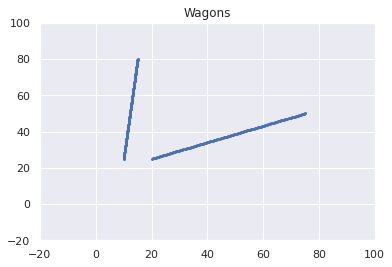

In [4]:
wagons.plot()

In [5]:
steps = int(1000/8)
n_agents = 40
pedestrians_wagons = []
targets = rng.uniform(-30,0,2*n_agents).reshape(2,n_agents)
positions = rng.uniform(80,100,2*n_agents).reshape(2,n_agents)
for agent in range(n_agents):
    pedestrians_wagons.append(Pedestrian(steps=steps,position=positions[:,agent],
                                  target=targets[:,agent],obstacles=wagons.obstacles))

#Simulate
simulate(pedestrians_wagons)

Runtime: 18.12


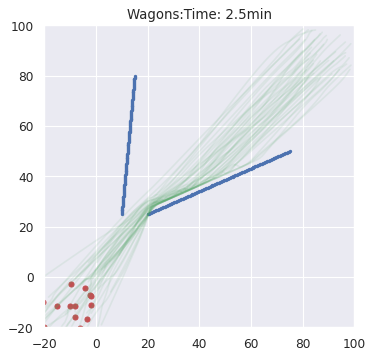

In [6]:
wagons.plot_flow(peds=pedestrians_wagons, alpha=.1)

In [7]:
obstacles_plot = wagons.obstacles_to_plot()


size = 2
@widgets.interact(n=(2,steps,5))
def plot(n=1,drag=10):
    plt.figure(figsize=(5,5), dpi=80)
    plt.title(f"Time: {int(np.floor(n/60))}.{n%60}min")
    #plt.xlim(-20,100)
    #plt.ylim(-20,100)
    for obstacle_ in obstacles_plot:
        plt.scatter(obstacle_[0], obstacle_[1], s=4, label=f"Barrier")
        plt.gca().set_prop_cycle(None)
    for ped in pedestrians_wagons:
        plt.scatter(ped.target[0],ped.target[1], s=20, label=f"{ped}")
    plt.gca().set_prop_cycle(None)
    for ped in pedestrians_wagons:
        plt.scatter(ped.history[0,max(1,n-drag):n],ped.history[1,max(1,n-drag):n], s=size, label=f"{ped}")

interactive(children=(IntSlider(value=2, description='n', max=125, min=2, step=5), IntSlider(value=10, descrip…

## Corridor with one-directional flow

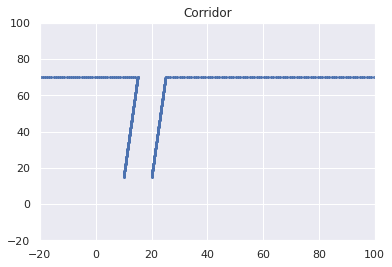

In [8]:
corridor.plot()

In [9]:
steps = int(1000/8)
n_agents = 30
pedestrians_corridor = []
targets = rng.uniform(-30,0,2*n_agents).reshape(2,n_agents)
positions = rng.uniform(80,100,2*n_agents).reshape(2,n_agents)
for agent in range(n_agents):
    pedestrians_corridor.append(Pedestrian(steps=steps,position=positions[:,agent],
                                  target=targets[:,agent],obstacles=corridor.obstacles))

#Simulate
simulate(pedestrians_corridor)

Runtime: 95.65


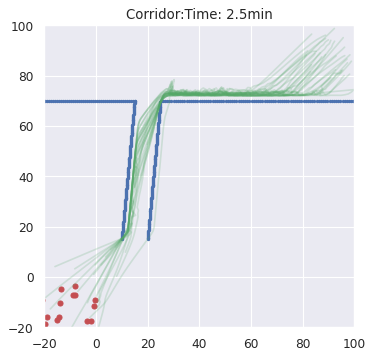

In [10]:
# Plot flows
corridor.plot_flow(peds=pedestrians_corridor, alpha=.2)

In [11]:
obstacles_plot = corridor.obstacles_to_plot()


size = 2
@widgets.interact(n=(2,steps,5))
def plot(n=1, drag = 10):
    plt.figure(figsize=(5,5), dpi=80)
    plt.title(f"Time: {int(np.floor(n/60))}.{n%60}min")
    plt.xlim(-20,100)
    plt.ylim(-20,100)
    for obstacle_ in obstacles_plot:
        plt.scatter(obstacle_[0], obstacle_[1], s=4, label=f"Barrier")
        plt.gca().set_prop_cycle(None)
    for ped in pedestrians_corridor:
        plt.scatter(ped.target[0],ped.target[1], s=20, label=f"{ped}")
    plt.gca().set_prop_cycle(None)
    for ped in pedestrians_corridor:
        plt.scatter(ped.history[0,max(1,n-drag):n],ped.history[1,max(1,n-drag):n], s=size, label=f"{ped}")

interactive(children=(IntSlider(value=2, description='n', max=125, min=2, step=5), IntSlider(value=10, descrip…

## Corridor with two-directional flow

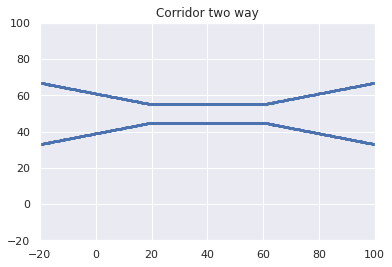

In [12]:
corridor_two_way.plot()

In [13]:
steps = int(1000/10)
n_agents = 50
n_agents_left, n_agents_right = int(n_agents/2), int(n_agents/2)
pedestrians_corridor_two_way = []
targets_left = rng.uniform(-30,-20,2*n_agents_left).reshape(2,n_agents_left)
targets_left[1,:] = 4*20 + targets_left[1,:]
targets_right =  rng.uniform(80,100,2*n_agents_right).reshape(2,n_agents_right)
targets_right[1,:] = -2*20 + targets_right[1,:]
targets = np.concatenate([targets_left,targets_right],axis=1)
positions_left =  rng.uniform(80,100,2*n_agents_left).reshape(2,n_agents_left)
positions_left[1,:] = -2*20 + positions_left[1,:]
positions_right = rng.uniform(-30,-20,2*n_agents_right).reshape(2,n_agents_right)
positions_right[1,:] = 4*20 + positions_right[1,:]
positions = np.concatenate([positions_left,positions_right],axis=1)
for agent in range(n_agents):
    pedestrians_corridor_two_way.append(Pedestrian(steps=steps,position=positions[:,agent],
                                  target=targets[:,agent],obstacles=corridor_two_way.obstacles))


#Simulate
simulate(pedestrians_corridor_two_way)

Runtime: 92.74


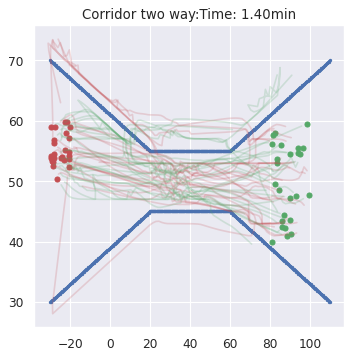

In [14]:
corridor_two_way.plot_flow(peds=pedestrians_corridor_two_way, 
                           groups=2, 
                           alpha=.2, 
                           n_agents_left=n_agents_left)

In [15]:
obstacles_plot = corridor_two_way.obstacles_to_plot()


@widgets.interact(n=(2, steps, 5))
def plot(n=1, drag=10, size=.2):
    plt.figure(figsize=(5,5), dpi=80)
    plt.title(f"{corridor_two_way.name} - Time: {int(np.floor(n/60))}.{n%60}min")
    #plt.xlim(-20,100)
    #plt.ylim(-20,100)
    for obstacle_ in obstacles_plot:
        plt.scatter(obstacle_[0], obstacle_[1], s=4, label=f"Barrier")
        plt.gca().set_prop_cycle(None)
    for i, ped in enumerate(pedestrians_corridor_two_way):
        if i < n_agents_left:
            color = "r"
        else:
            color = "g"
        plt.scatter(ped.target[0],ped.target[1], s=20, label=f"{ped}", color=color)
    for i, ped in enumerate(pedestrians_corridor_two_way):
        if i < n_agents_left:
            color = "r"
        else:
            color = "g"
        plt.scatter(ped.history[0,max(1,n-drag):n],ped.history[1,max(1,n-drag):n], s=size, label=f"{ped}", color=color)

interactive(children=(IntSlider(value=2, description='n', min=2, step=5), IntSlider(value=10, description='dra…

In [16]:
# Flow plot
obstacles_plot = corridor_two_way.obstacles_to_plot()

drag = steps
size = .1
@widgets.interact(n=(2,steps,5))
def plot(n=steps):
    plt.figure(figsize=(5,5), dpi=80)
    plt.title(f"{corridor_two_way.name}:Time: {int(np.floor(n/60))}.{n%60}min")
    #plt.xlim(-20,100)
    #plt.ylim(-20,100)
    for obstacle_ in obstacles_plot:
        plt.scatter(obstacle_[0], obstacle_[1], s=4, label=f"Barrier")
        plt.gca().set_prop_cycle(None)
    for i, ped in enumerate(pedestrians_corridor_two_way):
        if i < n_agents_left:
            color = "r"
        else:
            color = "g"
        plt.plot(ped.target[0],ped.target[1], alpha=size, label=f"{ped}", color=color)
    for i, ped in enumerate(pedestrians_corridor_two_way):
        if i < n_agents_left:
            color = "r"
        else:
            color = "g"
        plt.plot(ped.history[0,max(1,n-drag):n],ped.history[1,max(1,n-drag):n], alpha=size, label=f"{ped}", color=color)

interactive(children=(IntSlider(value=100, description='n', min=2, step=5), Output()), _dom_classes=('widget-i…